# **Masses** - **Cedric Liang**

Now that we have our magnitudes in each band, we can perform science. One of the areas of interest in analysing an open cluster is analysing the mass distribution characteristics of the stars in our cluster.

We can do this by calculating the temperature of each star from its colour, then using a fit (we'll be using Malkov 2007 and Hillenbrand & White 2004) that relates temperature and mass to get those values.

We'll begin by importing the observed apparent magnitudes table.

In [2]:
import numpy as np
from astropy import units as u
import astropy.table
from astropy.table import QTable
import matplotlib.pyplot as plt
import os
import warnings
import operator
from functools import partial
warnings.filterwarnings('ignore')
ROOT_PATH = os.path.normpath(os.getcwd() + os.sep + os.pardir)

In [3]:
mag_table = astropy.table.Table.read('obj_magnitudes.ecsv')
mag_table[:10]

id,xcenter,ycenter,Bmag,Vmag,Rmag
int64,float64,float64,float64,float64,float64
1,558.5821422495022,1.553447827399145,15.68928535739459,15.275841761053973,15.244903270383979
2,215.4588279399274,3.983022591080132,15.815771119099008,15.906980234932634,15.342412892913183
4,1373.7256085823674,13.534586033156419,14.203652326627292,14.078608650094244,14.026161934201072
5,733.2994363144586,13.335078874553421,15.885125083628285,14.929816212545855,14.504504540481872
6,1181.245040725141,13.348170003563451,15.885390773321472,15.02501002741372,15.007060184080622
7,336.13127255653905,17.162987601026444,15.609194810018852,15.290687290701829,14.847589411718948
8,788.9605066759916,16.500805548609634,13.018608379573829,12.747147500124049,12.532762523790582
9,144.72496142271015,18.682891776588065,15.145567356395862,15.57209316267854,15.013918170998622
11,1366.7676792434581,22.887029930438892,13.32410322845106,13.24406093481389,13.168136453554364


We'll now use the work with regards to object filtering that we did in Isochrones in order to get rid of objects that are too far from the isochrone, and hence are expected to be foreground or background objects.

In [4]:
import json

with open('removed_ids.dat', 'r') as f:
    removed_ids = json.load(f)

print(removed_ids)

[2, 9, 15, 16, 23, 27, 32, 34, 43, 60, 62, 64, 68, 83, 95, 99, 110, 113, 118, 120, 121, 124, 128, 136, 139, 149, 150, 161, 167, 170, 176, 181, 190, 195, 203, 212, 220, 225, 230, 232, 245, 250, 251, 252, 258, 273, 275, 283, 292, 299, 302, 313, 316, 322, 325, 330, 345, 362, 364, 369, 375, 385, 387, 393, 395, 398, 399, 408, 413, 419, 421, 422, 428, 434, 439, 448, 454, 459, 462, 463, 474, 483, 484, 486, 495, 496, 535, 536, 540, 547, 548, 552, 557, 561, 563, 566, 567, 570, 573, 576, 582, 593, 594, 599, 600, 603, 622, 627, 630, 631, 632, 634, 637, 639, 640, 646, 648, 656, 657, 673, 676, 682, 683, 687, 688, 690, 692, 693, 698, 699, 700, 706, 710, 716, 726, 727, 738, 740, 741, 759, 761, 765, 768, 771, 777, 779, 783, 784, 796, 802, 809, 810]


### Colour to Temperature

We'll use the PyAstronomy package and its inbuilt conversion function to convert between colour index and temperature. This implements the formula derived by Ballesteros 2012 (EPL 97, 34008).

In [5]:
from PyAstronomy import pyasl
b = pyasl.BallesterosBV_T()


In [6]:
extinction = 1
reddening = extinction/3.1

In [7]:
bvs = [{'id': row['id'], 'bv':(bv := row['Bmag']-row['Vmag']-reddening), 'temp':b.bv2T(bv)}
       for row
       in mag_table
       # filtering for the removed stars
       if int(row['id']) not in removed_ids
       ]

bvs[:10]


[{'id': 1, 'bv': 0.09086295117932658, 'temp': 9116.924510641818},
 {'id': 4, 'bv': -0.19753696862824227, 'temp': 13525.681287841673},
 {'id': 5, 'bv': 0.6327282259211395, 'temp': 5842.283490148272},
 {'id': 6, 'bv': 0.5378001007464623, 'temp': 6222.274952391603},
 {'id': 7, 'bv': -0.004073125844266834, 'temp': 10176.330096273798},
 {'id': 8, 'bv': -0.05111976571151039, 'temp': 10811.216060932504},
 {'id': 11, 'bv': -0.24253835152412, 'temp': 14705.557921243739},
 {'id': 12, 'bv': 0.49513482933148517, 'temp': 6411.0366317459875},
 {'id': 13, 'bv': 0.33241559033783447, 'temp': 7261.8795707173},
 {'id': 14, 'bv': 0.07425603535341957, 'temp': 9284.327016105557}]

We now have our list of temperatures! We'll have to be cognizant of outliers in our fit as it is not necessarily the case that all our stars are in cluster. Case in point - the star with ID 2 is hot and very blue, but has low overall magnitude numbers compared to the other stars. Given it has a low ID value, it makes intuitive sense why this might be a foreground/background star - it's on the periphery of the image. But it's just an example of how we have to be careful about whether our stars are foreground or not, and to make sure to filter and discard them before we do any sort of computational fit.

I'll now define the fit function that relates log temperature to Solar mass.

In [8]:
def t2mratio(teff):
    logteff = np.log10(teff)

    # out of range of fit
    if logteff < 3.453 or logteff > 4.613:
        return None

    if logteff < 3.523:
        logmratio = (-2.781774*10**1) + 7.786002*logteff

    # apply polynomial.
    else:
        logmratio = (
            (-8.448396*10**1) +
            (6.094505*10**1)*logteff +
            (-1.489538*10**1)*logteff**2 +
            (1.240992)*logteff**3
        )
    
    return 10**logmratio


In [9]:
for d in bvs:
    d['massratio'] = t2mratio(d['temp'])

# remove invalid elements which were out of the range of fit
bvs = [bv for bv in bvs if bv['massratio']]

bvs[:10]


[{'id': 1,
  'bv': 0.09086295117932658,
  'temp': 9116.924510641818,
  'massratio': 2.184602201821502},
 {'id': 4,
  'bv': -0.19753696862824227,
  'temp': 13525.681287841673,
  'massratio': 3.744588035334494},
 {'id': 5,
  'bv': 0.6327282259211395,
  'temp': 5842.283490148272,
  'massratio': 1.155181496261149},
 {'id': 6,
  'bv': 0.5378001007464623,
  'temp': 6222.274952391603,
  'massratio': 1.2721910857486056},
 {'id': 7,
  'bv': -0.004073125844266834,
  'temp': 10176.330096273798,
  'massratio': 2.534507639426196},
 {'id': 8,
  'bv': -0.05111976571151039,
  'temp': 10811.216060932504,
  'massratio': 2.750490937891121},
 {'id': 11,
  'bv': -0.24253835152412,
  'temp': 14705.557921243739,
  'massratio': 4.221024826624795},
 {'id': 12,
  'bv': 0.49513482933148517,
  'temp': 6411.0366317459875,
  'massratio': 1.3304920044302049},
 {'id': 13,
  'bv': 0.33241559033783447,
  'temp': 7261.8795707173,
  'massratio': 1.594849686073684},
 {'id': 14,
  'bv': 0.07425603535341957,
  'temp': 9284.

Great! We have our masses. Let's plot it to see how it is distributed.

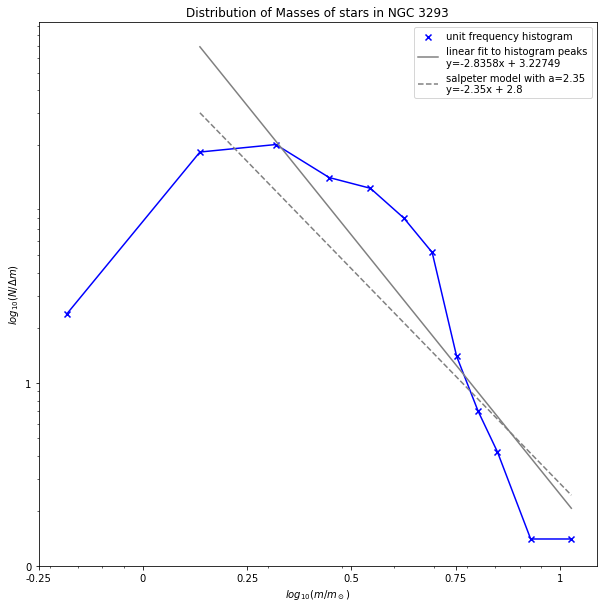

In [21]:
def compose(f, g):
    return lambda *a, **kw: f(g(*a, **kw))


# bin in linear scale
masslist = [star['massratio'] for star in bvs]

xrange = (0.3, 11)
numbins = 15
binsize = (xrange[1]-xrange[0])/numbins


histys, histbinedges = np.histogram(masslist, bins=np.linspace(xrange[0], xrange[1], numbins + 1))
histbinleftedge, histbinrightedge = histbinedges[:-1], histbinedges[1:]
histxs = list(map(compose(partial(operator.mul, 1/2), operator.add), histbinleftedge, histbinrightedge))

histys_unit = [y/binsize for y in histys]

# get rid of empty bins
plotxs, plotys = [], []
for xpoint, ypoint in zip(histxs, histys_unit):
    if ypoint:
        plotxs.append(xpoint)
        plotys.append(ypoint)

loghistxs = np.log10(np.array(plotxs))[1:]
loghistys = np.log10(np.array(plotys))[1:]

# make lin fit
linfit = np.polyfit(loghistxs, loghistys, 1)

# salpeter
salpeter = [-2.35, 2.8]

x_ticks = [10**-0.25, 1, 10**0.25, 10**0.5, 10**0.75, 10**1]
x_tick_labels = [-0.25, 0, 0.25, 0.5, 0.75, 1]

y_ticks = [1, 10]
y_tick_labels = [0, 1]

plt.rcParams["figure.figsize"] = (10, 10)
plt.scatter(plotxs, plotys, marker='x', color='b', label='unit frequency histogram')
plt.plot(plotxs, plotys, color='b')
# our linfit
plt.plot(10**(loghistxs), 10**((lambda x: x * linfit[0] + linfit[1])(loghistxs)), color='grey', label=f'linear fit to histogram peaks\ny={str(linfit[0])[:7]}x + {str(linfit[1])[:7]}')
# salpeter fit for stars above 1 solar mass
plt.plot(10**(loghistxs), 10**((lambda x: x * salpeter[0] + salpeter[1])(loghistxs)),color='grey', label=f'salpeter model with a=2.35\ny={str(salpeter[0])[:7]}x + {str(salpeter[1])[:7]}', linestyle='dashed', )


plt.xscale('log')
plt.yscale('log')
plt.xticks([], [])
plt.xticks(x_ticks, x_tick_labels)
plt.yticks([], [])
plt.yticks(y_ticks, y_tick_labels)
plt.ylabel("$log_{10}(N/{\Delta m})$")
plt.xlabel("$log_{10}(m/{m_\odot}$)")
plt.title("Distribution of Masses of stars in NGC 3293")
plt.legend(loc='best')
plt.show()


Looks good!